## Library Imports

In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import hdbscan
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore", category=FutureWarning)

## Explorations

#### Read Data

In [ ]:
# Load dataset
top_df = pd.read_csv('./tiktok_top.csv')

In [ ]:
print(top_df.isnull().sum())

Country              0
Rank                 0
Account              0
Title                2
Link                 0
Subscribers count    0
Views avg.           0
Likes avg.           0
Comments avg.        0
Shares avg.          0
Scraped              0
dtype: int64


In [ ]:
# Select only the 5 numeric columns and rename them
top_df = top_df[['Subscribers count', 'Views avg.', 'Likes avg.', 'Comments avg.', 'Shares avg.']].copy()

# Rename the columns
top_df.columns = ['followers', 'average_views', 'average_likes', 'average_comments', 'average_shares']

# Display the updated DataFrame
top_df.head()

,followers,average_views,average_likes,average_comments,average_shares
0,41600000.0,95000000.0,18100000.0,151000.0,54800.0
1,13400000.0,33300000.0,7300000.0,101900.0,106800.0
2,11400000.0,25000000.0,3000000.0,21800.0,64200.0
3,135400000.0,18700000.0,2600000.0,54700.0,35200.0
4,263700.0,16700000.0,1400000.0,16200.0,138400.0


Next, we check for missing values and compute basic descriptive statistics. The only missing values are in the name column, which we can ignore since they won’t affect numeric analysis. No missing data appears in the numeric engagement fields.

#### Data Quality Report

In [ ]:
# Summary statistics for engagement metrics
top_df.describe().T.map(lambda x: f"{x:,.2f}")

,count,mean,std,min,25%,50%,75%,max
followers,"1,000.00","7,049,170.10","10,872,669.22","4,300.00","1,400,000.00","3,700,000.00","8,625,000.00","135,400,000.00"
average_views,"1,000.00","3,700,866.30","4,697,163.71","585,300.00","1,800,000.00","2,600,000.00","4,000,000.00","95,000,000.00"
average_likes,"1,000.00","453,740.70","696,475.98","31,000.00","230,450.00","320,200.00","478,375.00","18,100,000.00"
average_comments,"1,000.00","4,559.05","7,766.15",0.00,"1,600.00","2,800.00","4,900.00","151,000.00"
average_shares,"1,000.00","10,681.08","167,772.38",212.00,"1,200.00","2,400.00","5,400.00","5,300,000.00"


In [ ]:
numeric_cols = ['followers', 'average_views', 'average_likes', 'average_comments', 'average_shares']

#### Box Plot

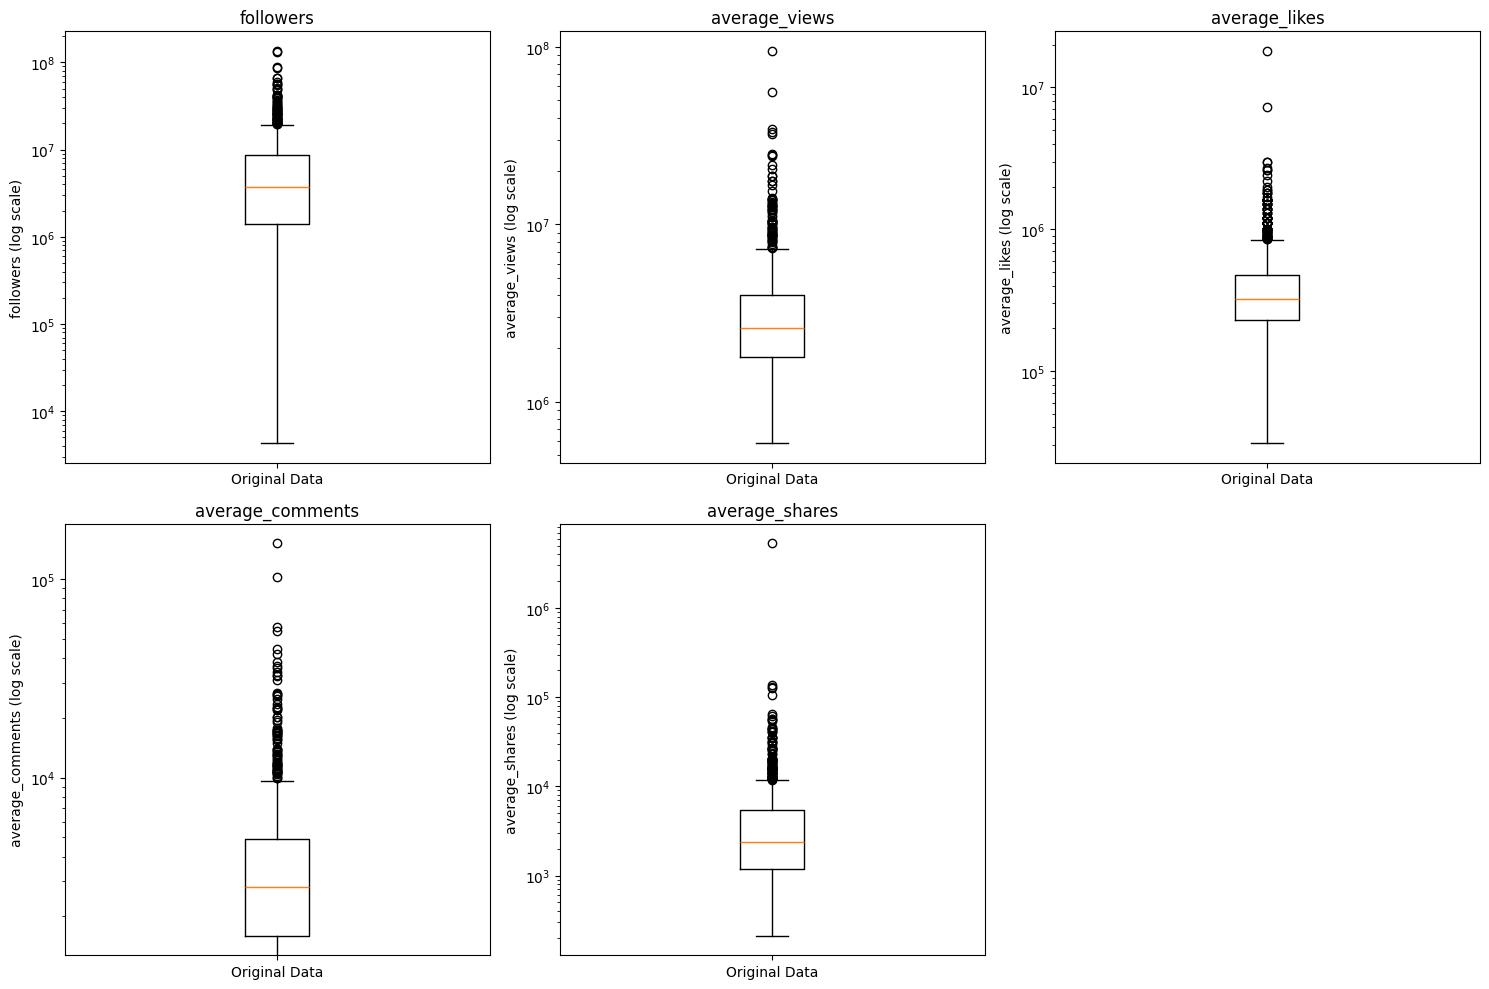

In [ ]:
# Define the metrics to plot
# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot boxplots for original data only
for i, metric in enumerate(numeric_cols):
    data_to_plot = [top_df[metric].dropna()]
    axes[i].boxplot(data_to_plot, tick_labels=['Original Data'], showfliers=True)
    axes[i].set_yscale('log')
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric + " (log scale)")

# Hide the last unused subplot
axes[-1].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

#### Outlier Summary with IQR Method

In [ ]:
# Dictionary to store threshold info and outlier counts
outlier_info = {}

# Loop through each column to compute thresholds and count outliers
for col in numeric_cols:
    data = top_df[col].dropna()
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = (top_df[col] < lower) | (top_df[col] > upper)
    count = outliers.sum()

    outlier_info[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Threshold': lower,
        'Upper Threshold': upper,
        'Outlier Count': count
    }

# Create a summary DataFrame
outlier_summary = pd.DataFrame(outlier_info).T
outlier_summary

,Q1,Q3,IQR,Lower Threshold,Upper Threshold,Outlier Count
followers,1400000.0,8625000.0,7225000.0,-9437500.0,19462500.0,70.0
average_views,1800000.0,4000000.0,2200000.0,-1500000.0,7300000.0,75.0
average_likes,230450.0,478375.0,247925.0,-141437.5,850262.5,93.0
average_comments,1600.0,4900.0,3300.0,-3350.0,9850.0,79.0
average_shares,1200.0,5400.0,4200.0,-5100.0,11700.0,98.0


In [ ]:
# Create a boolean mask DataFrame to track outliers per column
outlier_masks = pd.DataFrame()

for col in numeric_cols:
    Q1 = np.percentile(top_df[col].dropna(), 25)
    Q3 = np.percentile(top_df[col].dropna(), 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_masks[col + '_outlier'] = (top_df[col] < lower) | (top_df[col] > upper)

# Combine all masks into a single boolean Series
has_any_outlier = outlier_masks.any(axis=1)

# Count and extract the rows with at least one outlier
num_rows_with_outlier = has_any_outlier.sum()
outlier_rows = top_df[has_any_outlier]

print(f"Number of rows with at least one outlier: {num_rows_with_outlier}")


Number of rows with at least one outlier: 255


##### **Outlier Clamped**

In [ ]:
def clamp_iqr_outliers(df, cols):
    clamped_df = df.copy()
    for col in cols:
        Q1 = clamped_df[col].quantile(0.25)
        Q3 = clamped_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Clamp values outside the bounds
        clamped_df[col] = clamped_df[col].clip(lower=lower_bound, upper=upper_bound)
    return clamped_df

# Clamp extreme values instead of removing them
top_df_clamped = clamp_iqr_outliers(top_df, numeric_cols)

# Log-transform
X_top_clamped = top_df_clamped[numeric_cols].values
X_log_clamped = np.log10(X_top_clamped + 1)

# MinMax scaling
minmax_scaler_clamped = MinMaxScaler()
X_log_minmax_scaled_clamped = minmax_scaler_clamped.fit_transform(X_log_clamped)

#### Raw Vs Log Scaled Histogram

> Add blockquote



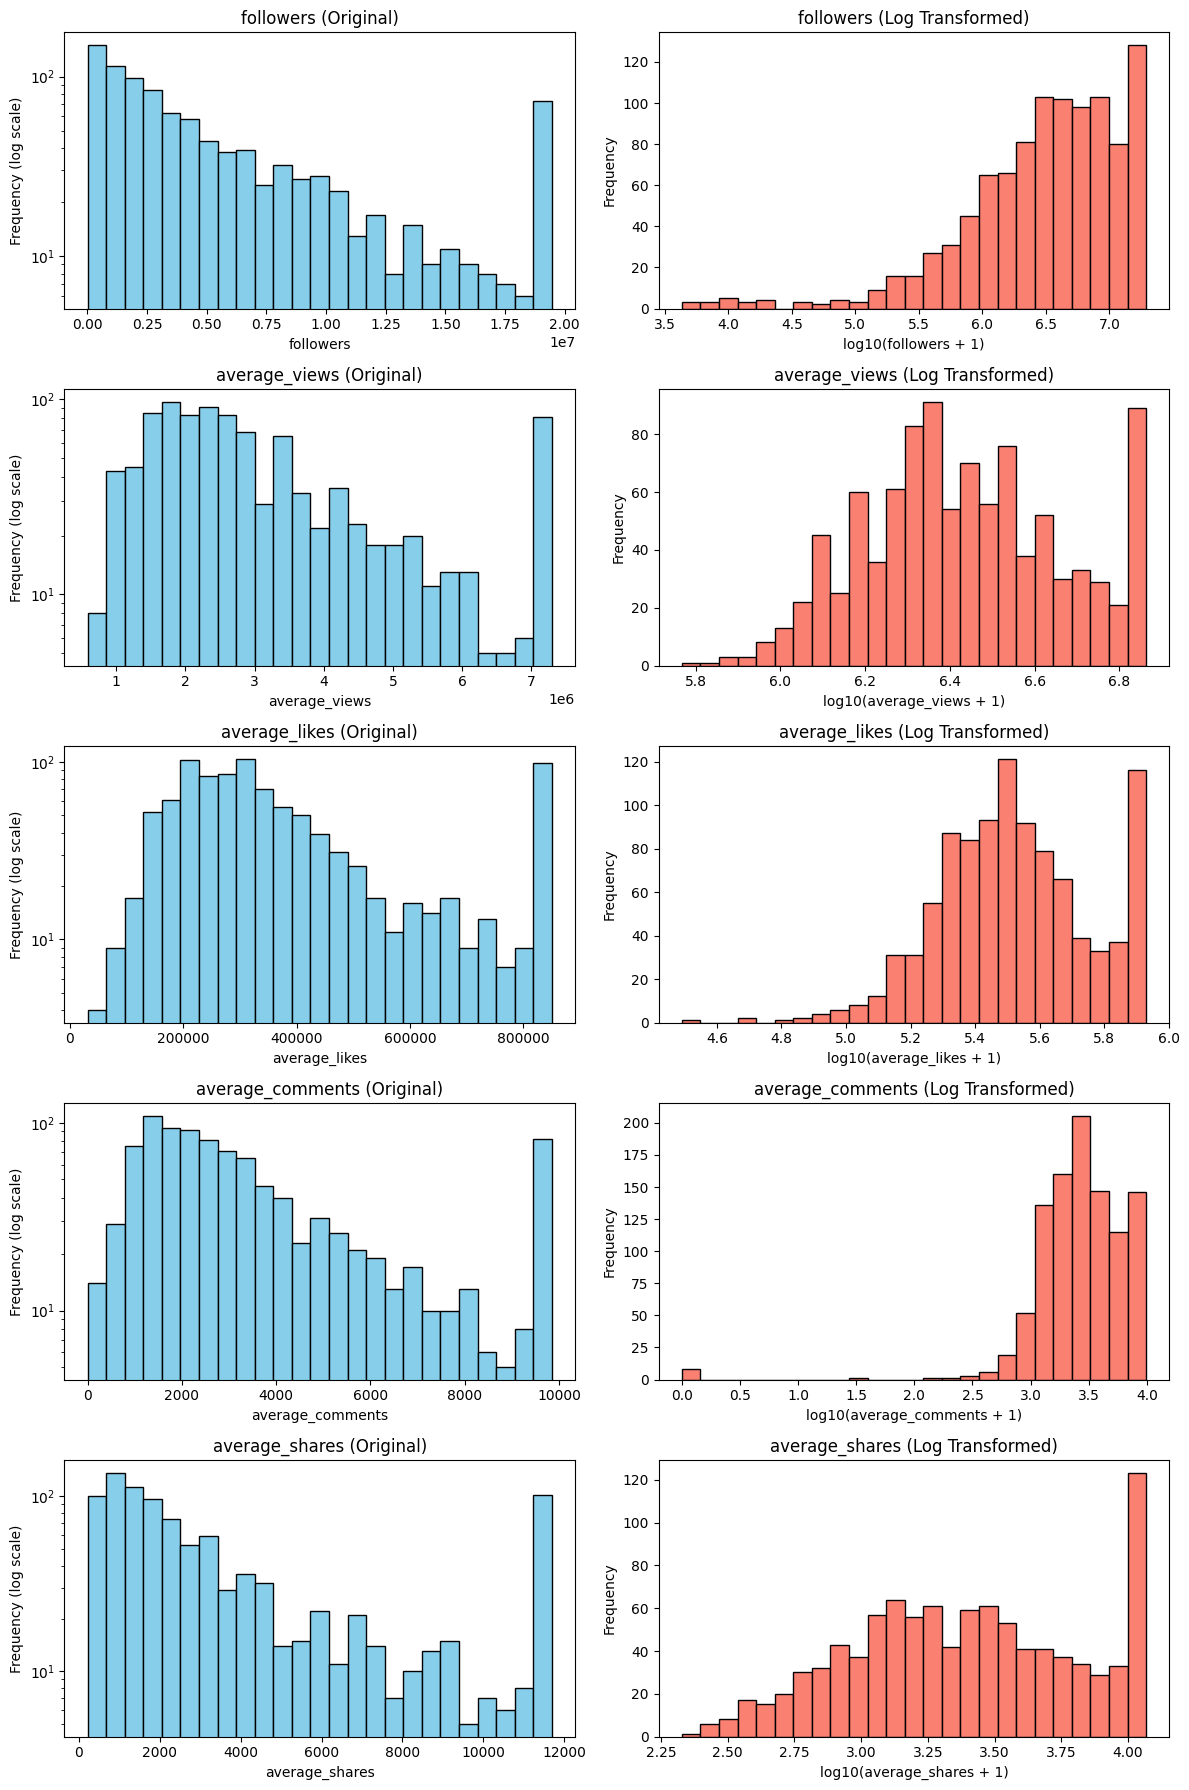

In [ ]:
# Plot original and log-transformed histograms side by side
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 18))
for i, col in enumerate(numeric_cols):
    # Original histogram (log frequency scale)
    axes[i, 0].hist(top_df_clamped[col].dropna(), bins=25, color='skyblue', edgecolor='black', log=True)
    axes[i, 0].set_title(f"{col} (Original)")
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel("Frequency (log scale)")
    #axes[i, 0].xaxis.set_major_formatter(FuncFormatter(format_func))  # Apply number formatting

    # Log-transformed histogram
    log_vals = np.log10(top_df_clamped[col].dropna() + 1)  # Add 1 to avoid log(0)
    axes[i, 1].hist(log_vals, bins=25, color='salmon', edgecolor='black')
    axes[i, 1].set_title(f"{col} (Log Transformed)")
    axes[i, 1].set_xlabel(f"log10({col} + 1)")
    axes[i, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

The distributions are right-skewed. This confirms that log transformation is necessary before clustering to reduce the dominance of extreme outliers.

## Clustering

#### **K-means Clustering**

##### **Determining Optimal Cluster number**

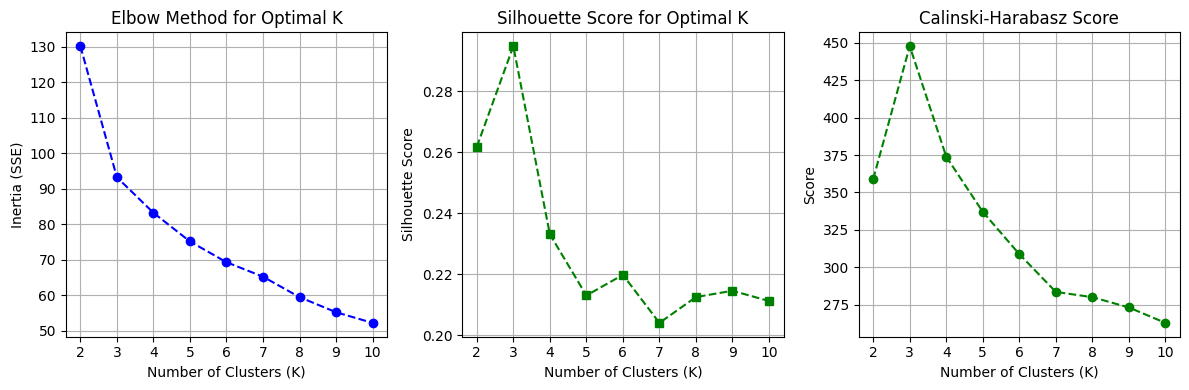

In [ ]:
# Evaluate K from 2 to 10 using inertia (elbow) and silhouette score
inertias = []
silhouette_scores = []
ch_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_log_minmax_scaled_clamped)
    score = calinski_harabasz_score(X_log_minmax_scaled_clamped, labels)
    ch_scores.append(score)
    inertias.append(kmeans.inertia_)  # Sum of squared distances to cluster centers
    silhouette_scores.append(silhouette_score(X_log_minmax_scaled_clamped, labels))  # Silhouette score


plt.figure(figsize=(12, 4))

# Plot Elbow Method
plt.subplot(1, 3, 1)
plt.plot(range(2, 11), inertias, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal K')
plt.xticks(np.arange(2, 11, step=1))
plt.grid(True)

# Plot Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(range(2, 11), silhouette_scores, marker='s', linestyle='--', color='g')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.xticks(np.arange(2, 11, step=1))
plt.grid(True)

# Plot Calinski-Harabasz Score
plt.subplot(1, 3, 3)
plt.plot(range(2, 11), ch_scores, marker='o', linestyle='--', color='g')
plt.title("Calinski-Harabasz Score")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.xticks(np.arange(2, 11, step=1))
plt.grid(True)

plt.tight_layout()
plt.show()

##### **Cluster Visualization with PCA**

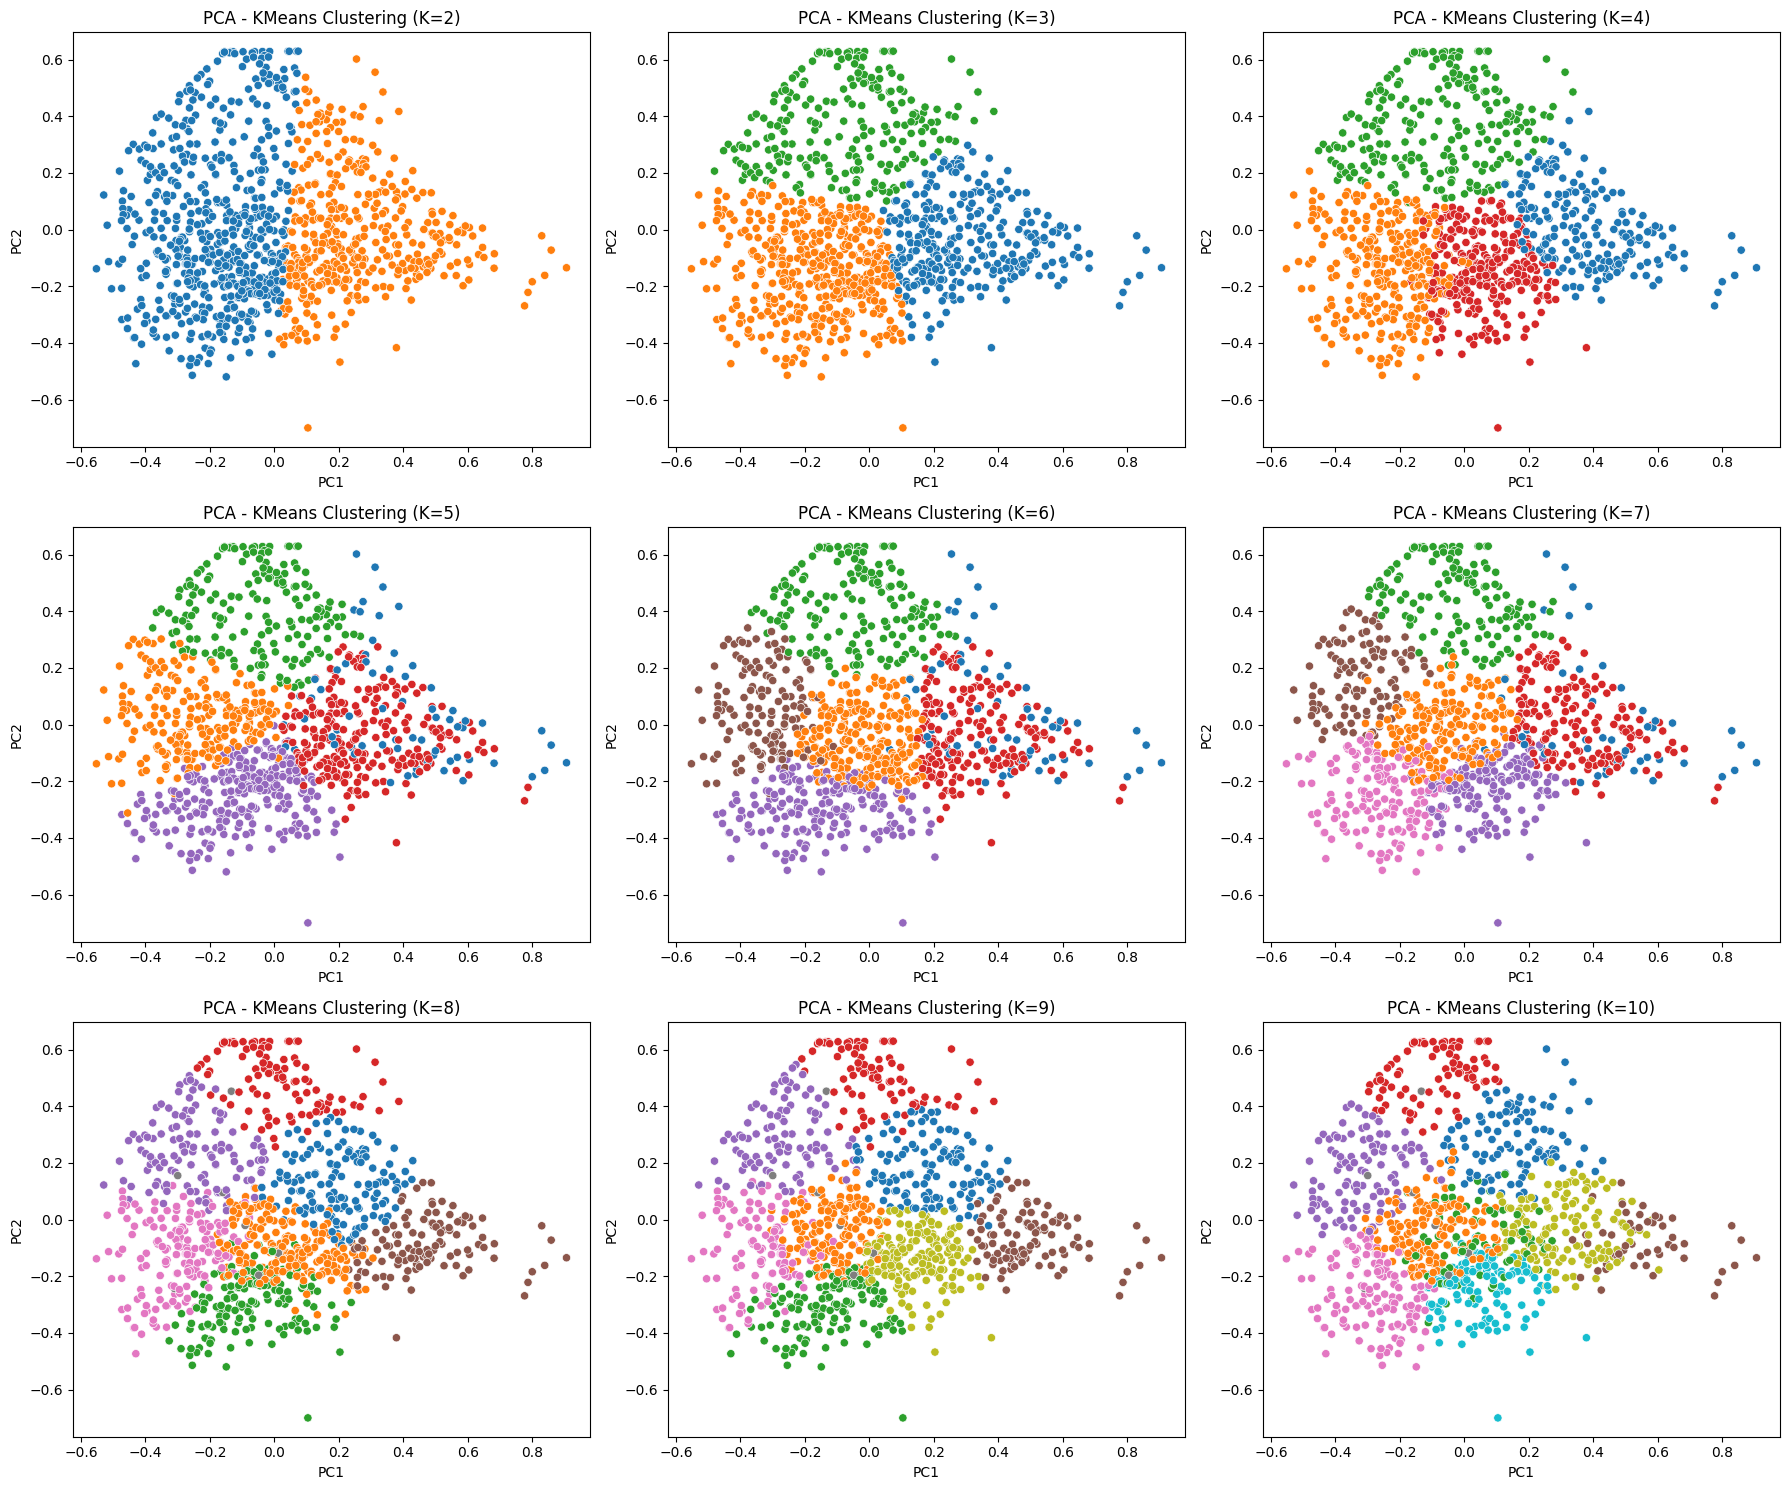

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_log_minmax_scaled_clamped)

# Step 3: Plot PCA scatterplots for K = 2 to 10
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, k in enumerate(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_log_minmax_scaled_clamped)

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=labels,
        palette='tab10', ax=axes[i], legend=False
    )
    axes[i].set_title(f"PCA - KMeans Clustering (K={k})")
    axes[i].set_xlabel("PC1")
    axes[i].set_ylabel("PC2")

plt.tight_layout()
plt.show()

##### **Cluster Visualization with t-SNE**

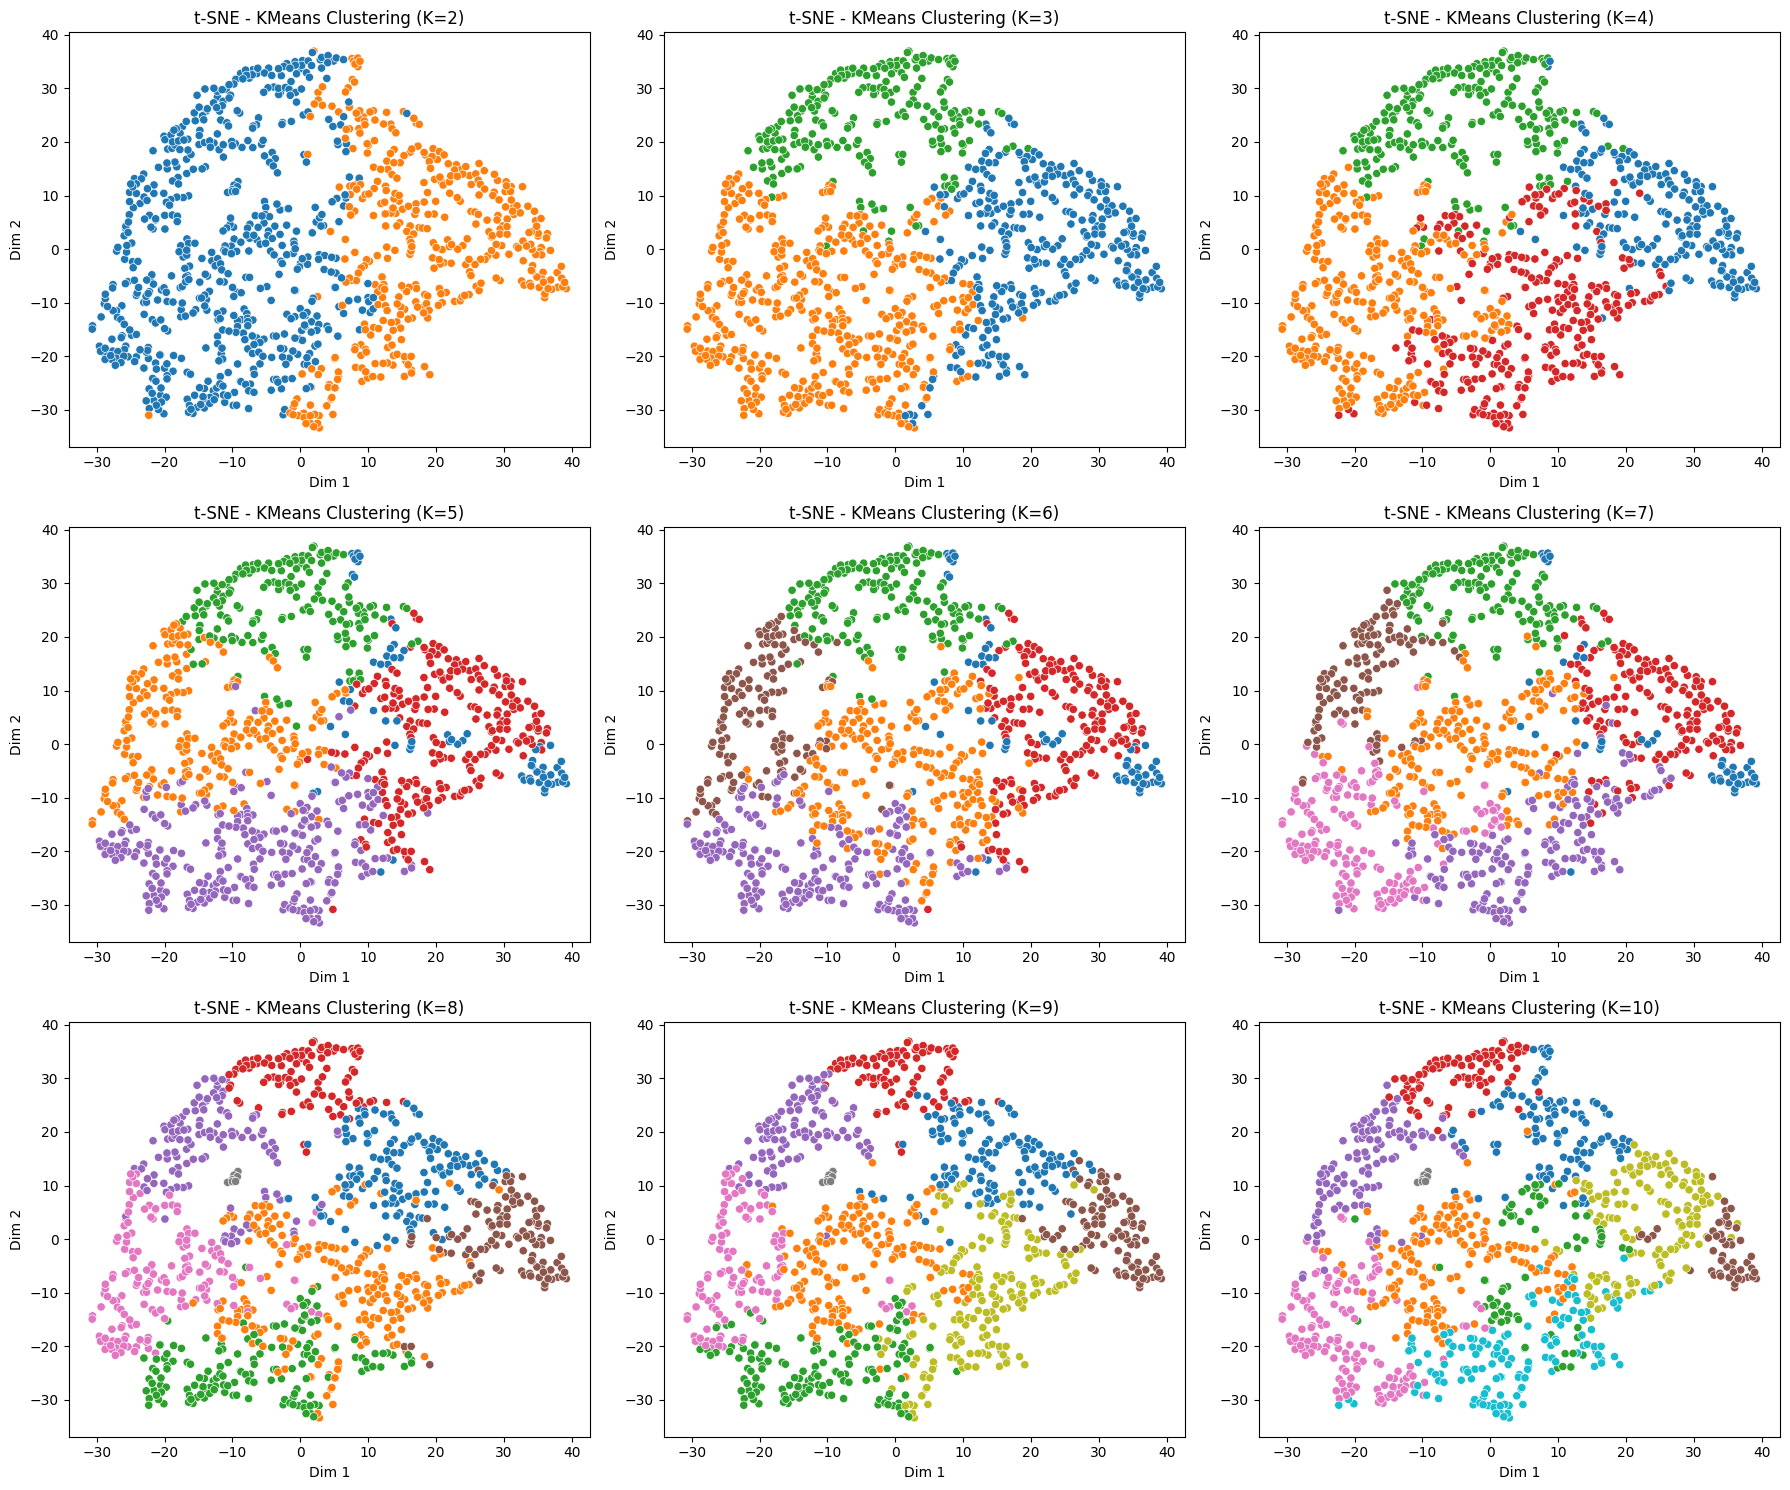

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_log_minmax_scaled_clamped)

# Plot t-SNE scatterplots for K = 2 to 10
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, k in enumerate(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_log_minmax_scaled_clamped)

    sns.scatterplot(
        x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels,
        palette='tab10', ax=axes[i], legend=False
    )
    axes[i].set_title(f"t-SNE - KMeans Clustering (K={k})")
    axes[i].set_xlabel("Dim 1")
    axes[i].set_ylabel("Dim 2")

plt.tight_layout()
plt.show()

##### **Cluster Summary**

In [ ]:
# Perform final KMeans with K=3 using K-means++ initialization
kmeans_pp = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=0)
labels_pp = kmeans_pp.fit_predict(X_log_minmax_scaled_clamped)
# Cluster sizes
unique, counts = np.unique(labels_pp, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

Cluster sizes: {np.int32(0): np.int64(317), np.int32(1): np.int64(455), np.int32(2): np.int64(228)}


In [ ]:
# Attach cluster labels to the top_df for analysis
top_df['cluster'] = labels_pp

# Calculate cluster-wise means of original metrics for interpretation
cluster_profiles = top_df.groupby('cluster')[numeric_cols].mean().round(2)
cluster_profiles.T

cluster,0,1,2
followers,2320509.46,8562618.90,10603407.89
average_views,1808095.58,3278461.54,7175438.60
average_likes,239264.04,350704.62,957558.77
average_comments,3322.81,2891.12,9606.41
average_shares,22923.59,1232.97,12514.47


##### Get some sample values from the clusters

In [ ]:
cluster_0 = top_df[top_df['cluster']==0].head(3)[['username','followers','average_views','average_likes','average_comments','average_shares']]
cluster_0

,username,followers,average_views,average_likes,average_comments,average_shares
41,mero_428,1300000,585300,70900,3000,5300000
159,com.yuta0305,960300,2500000,346300,20100,12800
181,tararistic4,607400,3400000,267200,3700,20300


In [ ]:
cluster_1 = top_df[top_df['cluster']==1].head(3)[['username','followers','average_views','average_likes','average_comments','average_shares']]
cluster_1

,username,followers,average_views,average_likes,average_comments,average_shares
62,ahw5d,2500000,10500000,649100,17700,689
100,soydekko,4400000,5800000,1100000,7700,853
149,fayx.lct,2900000,2600000,447100,25700,1200


In [ ]:
cluster_2 = top_df[top_df['cluster']==2].head(3)[['username','followers','average_views','average_likes','average_comments','average_shares']]
cluster_2

,username,followers,average_views,average_likes,average_comments,average_shares
0,billieeilish,41600000,95000000,18100000,151000,54800
1,badbunny,13400000,33300000,7300000,101900,106800
2,chipmunksoftiktok,11400000,25000000,3000000,21800,64200


#### **Hierarchichal Clustering**

##### **Determining Optimal Number of clusters**

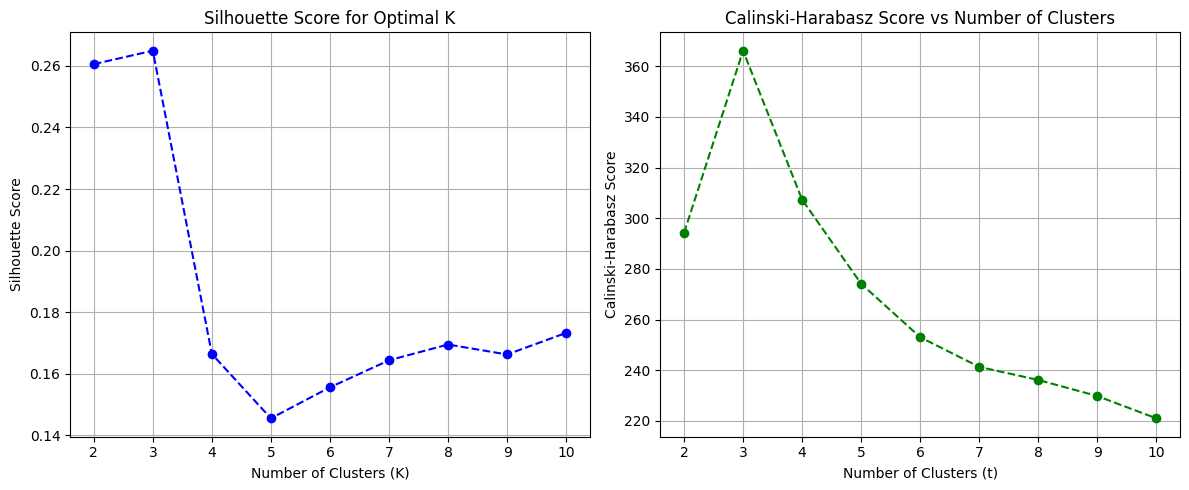

In [30]:
# Compute linkage matrix once
linked = linkage(X_log_minmax_scaled_clamped, method='ward')

# Evaluate K from 2 to 10
h_silhouette_scores = []
h_ch_scores = []

# Try different numbers of clusters
for t in range(2, 11):
    labels = fcluster(linked, t=t, criterion='maxclust')
    score = silhouette_score(X_log_minmax_scaled_clamped, labels)
    h_ch_scores.append(calinski_harabasz_score(X_log_minmax_scaled_clamped, labels))
    h_silhouette_scores.append(silhouette_score(X_log_minmax_scaled_clamped, labels))

plt.figure(figsize=(12, 5))

# Plot Silhouette Score
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), h_silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.grid(True)
# Plot Calinski-Harabasz Score
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), h_ch_scores, marker='o', linestyle='--', color='g')
plt.title("Calinski-Harabasz Score vs Number of Clusters")
plt.xlabel("Number of Clusters (t)")
plt.ylabel("Calinski-Harabasz Score")
plt.grid(True)

plt.tight_layout()
plt.show()


##### **Dendogram Visualization**

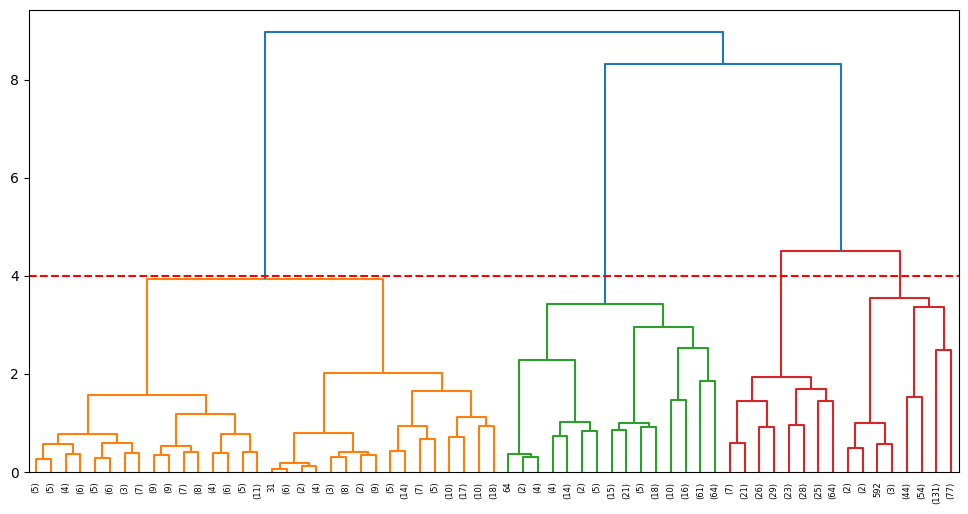

In [ ]:
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)  # Limit to 5 levels
plt.axhline(y=4, color='red', linestyle='--')  # Optional: visual cutoff
plt.show()

##### **Cluster Visualization with PCA**

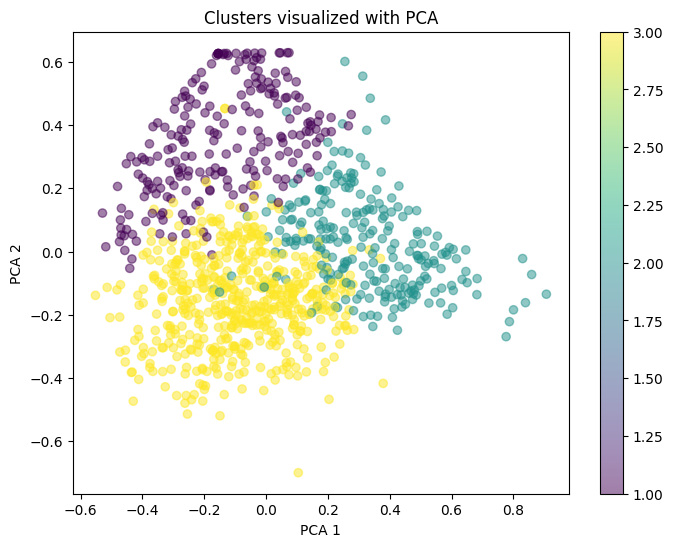

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_log_minmax_scaled_clamped)
h_labels = fcluster(linked, t=3, criterion='maxclust')  # t = desired number of clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=h_labels, cmap='viridis')
plt.title('Clusters visualized with PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

##### **Cluster Visualization with t-SNE**

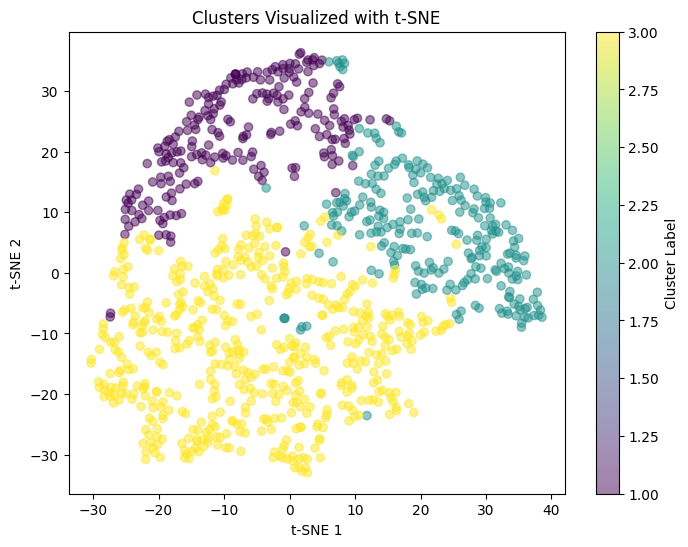

In [31]:
# Generate cluster labels from hierarchical clustering
h_labels = fcluster(linked, t=3, criterion='maxclust')  # t = desired number of clusters

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_log_minmax_scaled_clamped)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=h_labels, cmap='viridis', alpha=0.5)
plt.title('Clusters Visualized with t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster Label')
plt.show()

##### **Cluster Summary**

In [ ]:
# Attach cluster labels to the top_df for analysis
top_df['h_cluster'] = h_labels

# Calculate cluster-wise means of original metrics for interpretation
cluster_profiles = top_df.groupby('h_cluster')[numeric_cols].mean().round(2)
cluster_profiles.T

h_cluster,1,2,3
followers,11452637.10,1601000.00,7692170.02
average_views,7366515.84,2366671.07,2793541.71
average_likes,977165.16,269020.66,321572.07
average_comments,9436.03,3615.39,2977.21
average_shares,11427.54,30078.12,1632.56


#### **DBSCAN Clustering**

##### **Optimal number of clusters**

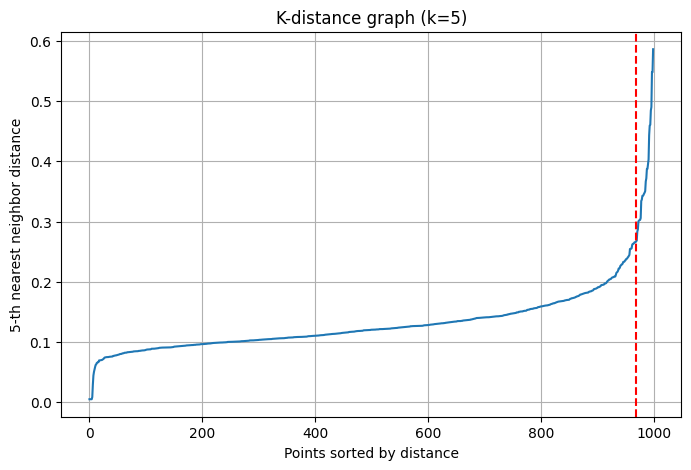

Initial recommended eps: 0.2659


In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

# === Step 1: Define X ===
X = X_log_minmax_scaled_clamped  # Use clamped, log-scaled, and normalized data

# === Step 2: Perform PCA on original features ===
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# === Step 3: Find eps using Kneedle ===
def find_eps_with_kneedle(X, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k - 1])

    kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    eps_value = distances[kneedle.knee] if kneedle.knee is not None else None

    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    if kneedle.knee is not None:
        plt.axvline(kneedle.knee, color='r', linestyle='--')
    plt.title(f"K-distance graph (k={k})")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}-th nearest neighbor distance")
    plt.grid(True)
    plt.show()

    return eps_value

initial_eps = find_eps_with_kneedle(X, k=5)
print(f"Initial recommended eps: {initial_eps:.4f}")

In [ ]:
# === Step 4: Grid search for eps and min_samples ===
eps_values = np.linspace(initial_eps * 0.7, initial_eps * 1.3, 10)
min_samples_values = range(3, 10)

results = []
best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:
            try:
                score = silhouette_score(X_pca[labels != -1], labels[labels != -1])
            except:
                score = -1

            results.append({
                "eps": eps,
                "min_samples": min_samples,
                "n_clusters": n_clusters,
                "n_noise": n_noise,
                "silhouette_score": score,
                "labels": labels
            })

            if score > best_score:
                best_score = score
                best_params = {"eps": eps, "min_samples": min_samples}


In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="silhouette_score", ascending=False, inplace=True)
top_3 = results_df.head(3).reset_index(drop=True)
top_3

,eps,min_samples,n_clusters,n_noise,silhouette_score,labels
0,0.239301,6,2,29,0.245204,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,0.239301,5,2,26,0.242616,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,0.257027,6,2,23,0.241757,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


<ipython-input-29-53398d025a7b>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


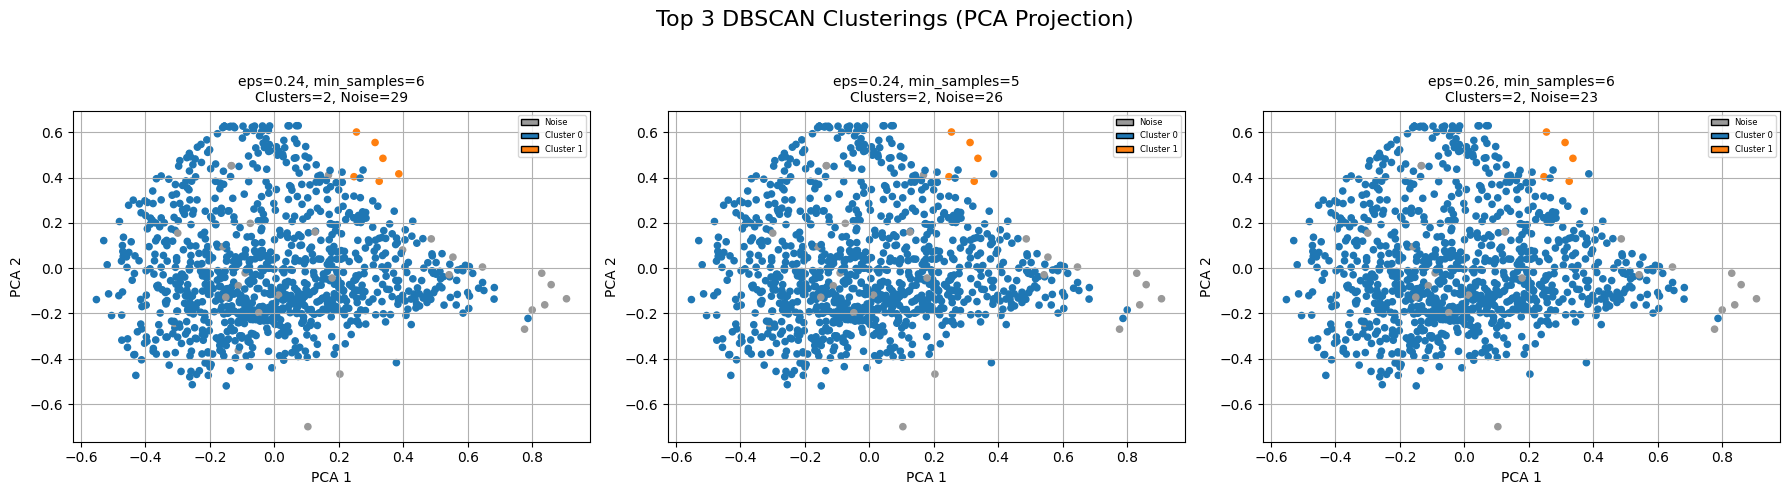

In [ ]:
# === Step 6: Plot the top 3 clusterings ===
cmap = cm.get_cmap('tab10')
fig, axes = plt.subplots(1, len(top_3), figsize=(6 * len(top_3), 5))

# Ensure axes is iterable
if len(top_3) == 1:
    axes = [axes]

for idx, row in top_3.iterrows():
    labels = row["labels"]
    eps = row["eps"]
    min_samples = row["min_samples"]
    n_clusters = row["n_clusters"]
    n_noise = row["n_noise"]

    ax = axes[idx]
    colors = [cmap(lbl % 10) if lbl != -1 else (0.6, 0.6, 0.6, 1.0) for lbl in labels]
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=20)

    # Add legend
    unique_labels = sorted(set(labels))
    legend_elements = []
    for lbl in unique_labels:
        color = cmap(lbl % 10) if lbl != -1 else (0.6, 0.6, 0.6, 1.0)
        label_name = f"Cluster {lbl}" if lbl != -1 else "Noise"
        legend_elements.append(Patch(facecolor=color, edgecolor='k', label=label_name))

    ax.legend(handles=legend_elements, fontsize=6, loc='upper right')
    ax.set_title(f"eps={eps:.2f}, min_samples={min_samples}\nClusters={n_clusters}, Noise={n_noise}", fontsize=10)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.grid(True)

plt.suptitle("Top 3 DBSCAN Clusterings (PCA Projection)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### **HDBSCAN Clustering**

In [ ]:
# Use clamped and normalized feature matrix
X = X_log_minmax_scaled_clamped

# PCA for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Parameter grid
min_cluster_sizes = list(range(3, 11))   # 3 to 10
min_samples_values = list(range(4, 11))  # 4 to 10

# Store results
results = []

for mcs in min_cluster_sizes:
    for ms in min_samples_values:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        labels = clusterer.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        try:
            sil_score = silhouette_score(X[labels != -1], labels[labels != -1]) if n_clusters > 1 else -1
        except:
            sil_score = -1

        results.append({
            'min_cluster_size': mcs,
            'min_samples': ms,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score,
            'labels': labels  # Save labels for later plotting
        })

# Convert to DataFrame and get top 2 by silhouette score
results_df = pd.DataFrame(results)
top_results = results_df.sort_values(by='silhouette', ascending=False).head(3).reset_index(drop=True)

In [ ]:
# Save results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='silhouette', ascending=False)
results_df.head()

,min_cluster_size,min_samples,n_clusters,n_noise,silhouette,labels
52,10,7,2,644,0.515212,"[1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, ..."
51,10,6,2,626,0.497433,"[0, 0, 0, 0, -1, 0, -1, 0, 0, 0, -1, 0, -1, 0,..."
7,4,4,2,0,0.482141,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
14,5,4,2,0,0.482141,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
35,8,4,2,0,0.482141,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


<ipython-input-29-c8d10be83a66>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


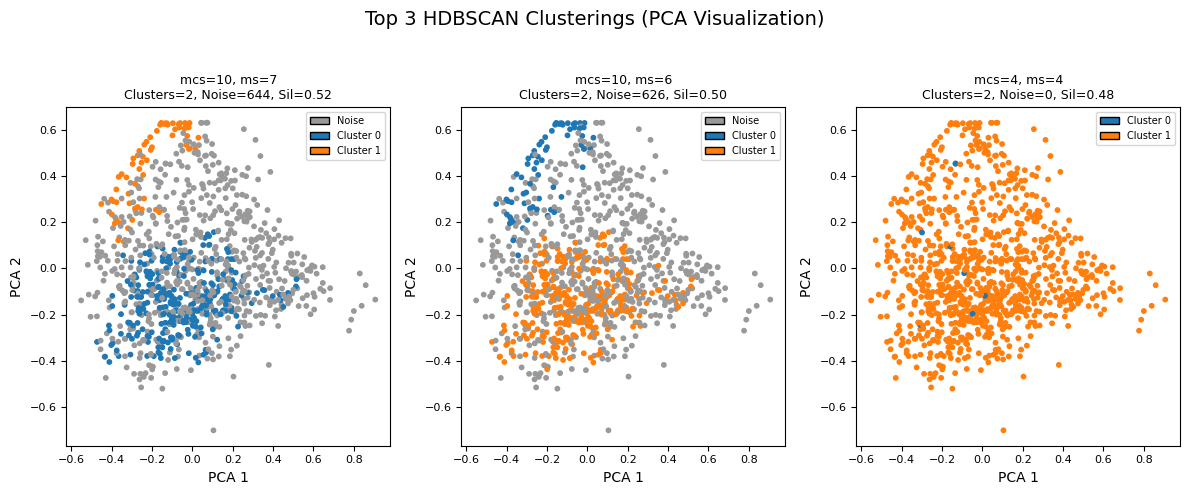

In [ ]:
# Plot settings
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
cmap = cm.get_cmap('tab10')

for idx, row in top_results.iterrows():
    ax = axes[idx]
    labels = row['labels']
    mcs = row['min_cluster_size']
    ms = row['min_samples']
    n_clusters = row['n_clusters']
    n_noise = row['n_noise']
    sil_score = row['silhouette']

    # Assign colors
    colors = [cmap(lbl % 10) if lbl != -1 else (0.6, 0.6, 0.6, 1.0) for lbl in labels]
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=10)

    # Legend
    unique_labels = sorted(set(labels))
    legend_elements = []
    for label in unique_labels:
        color = cmap(label % 10) if label != -1 else (0.6, 0.6, 0.6, 1.0)
        name = f"Cluster {label}" if label != -1 else "Noise"
        legend_elements.append(Patch(facecolor=color, edgecolor='k', label=name))

    ax.legend(handles=legend_elements, fontsize=7, loc='upper right')
    ax.set_title(f"mcs={mcs}, ms={ms}\nClusters={n_clusters}, Noise={n_noise}, Sil={sil_score:.2f}", fontsize=9)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.suptitle("Top 3 HDBSCAN Clusterings (PCA Visualization)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()